# Time Series Analysis with SARIMAX


Here we analyze 4 years of hourly energy consumption to find trends in energy consumption around hour of the day, day of the week, season of the year, etc. and also to examine factors like outside temperature and solar installations. The goal is to build to predict the energy consumption given parameters like day of the week, time of the day, season, holiday, local weather, solar installation, etc.

The energy consumption values can also be expected to depend on it’s previous lagged values because the energy consumption of a region shouldn’t be expected to change much in the next few hours except for any unexpected or unfortunate events. So we will add the lagged values of energy consumption as the X parameters and check if we can predict better using the past values (in addition to the variables that we had already added).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from green_city.utils import span
from green_city.utils import datetime2index, index2datetime
from green_city.plotting import plot_decomposition

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [27]:
building_nr = "all"
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building_nr": building_nr,
    "predicted_feature": column_to_predict,
    "resolution": "daily",
}

In [28]:
# Set to True to record values in mlflow and SQL database
write_data = True

if write_data:
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))

    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)


In [5]:
# Load data
#df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [7]:
y = df['net_load_kW']
df_train = df[['net_load_kW']].iloc[:(len(df)-365*24)]
df_test = df[['net_load_kW']].iloc[(len(df)-365*24):]

In [8]:
# Yearly, weekly and daily seasonality as exogenous variables for SARIMAX model
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['year_sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['year_cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['year_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['year_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog['week_sin365'] = np.sin(2 * np.pi * exog.index.dayofweek/7)
exog['week_cos365'] = np.cos(2 * np.pi * exog.index.dayofweek/7)
exog['week_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofweek/7)
exog['week_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofweek/7)
exog['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
exog['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
exog['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
exog['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 
exog['outdoor_temp'] = df['outdoor_temp'].values
exog['outdoor_hum'] = df['outdoor_hum'].values
exog['diffuse_solar_W_m2'] = df['diffuse_solar_W_m2'].values
exog['direct_solar_W_m2'] = df['direct_solar_W_m2'].values
exog = exog.drop(columns=['date'])

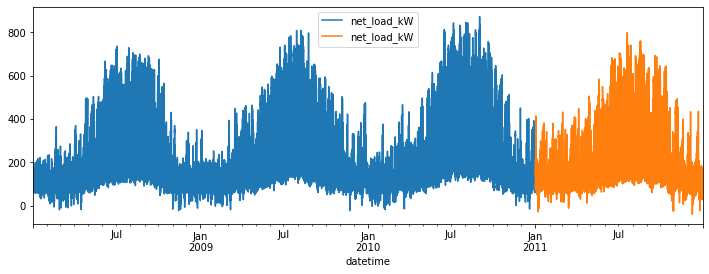

In [9]:
# Plot train and test data
fig, ax = plt.subplots(figsize=(12,4))
df_train[['net_load_kW']].plot(ax=ax, label='Train data')
df_test[['net_load_kW']].plot(ax=ax, label='Test data')
plt.legend()
plt.show()

In [10]:
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):] # last year for testing

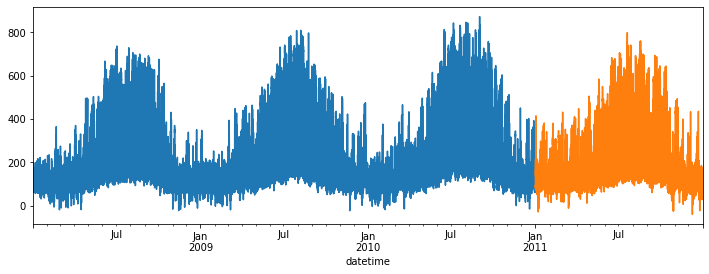

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
y_to_train.plot(ax=ax)
y_to_test.plot(ax=ax)
plt.show()

### Seasonal decomposition (one year period)

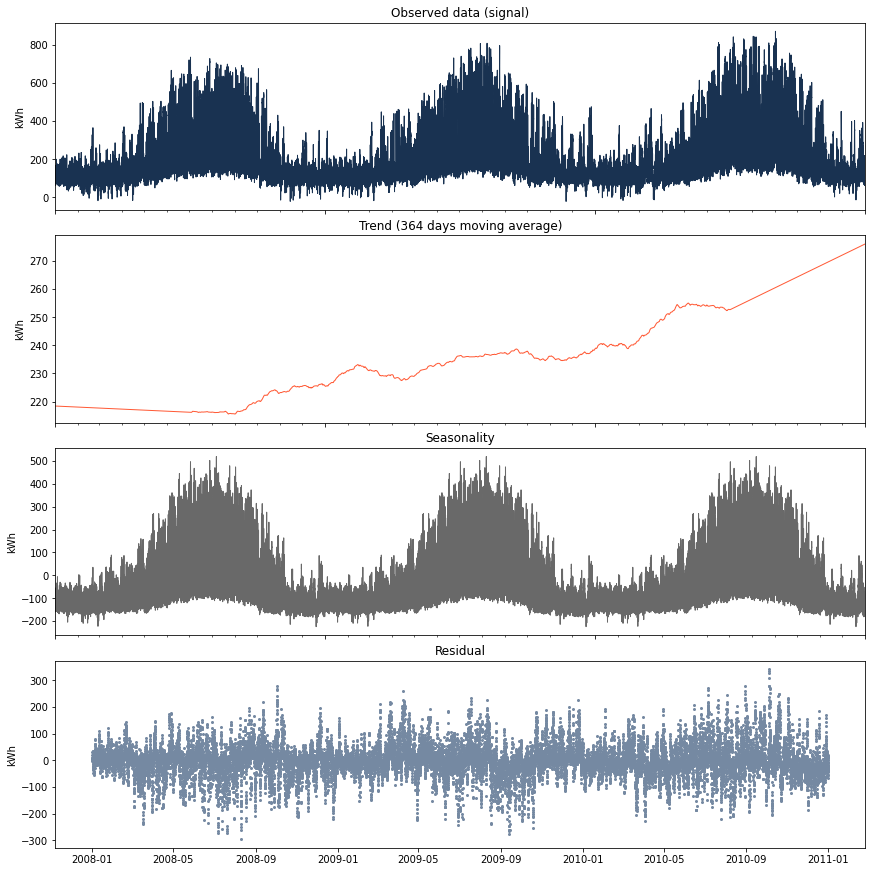

In [12]:
decomp = seasonal_decompose(
    x=y_to_train, 
    model='additive', 
    two_sided=True,
    extrapolate_trend=True,
    period= 24*365)

plot_decomposition(decomp)

### Multiple seasonal decomposition with MSTL

In [ ]:
# mstl = MSTL(y_to_train, periods=(24, 24*7, 24*365), stl_kwargs={"seasonal_deg": 0})
# res = mstl.fit() 

In [ ]:
# # Start with the plot from the results object `res`
# plt.rc("figure", figsize=(10, 14))
# plt.rc("font", size=13)
# fig = res.plot()

### Stationarity test on first difference of train data

In [13]:
#stationarity_test(y_to_train.diff().dropna())

NameError: name 'stationarity_test' is not defined

### ACF and PACF plots

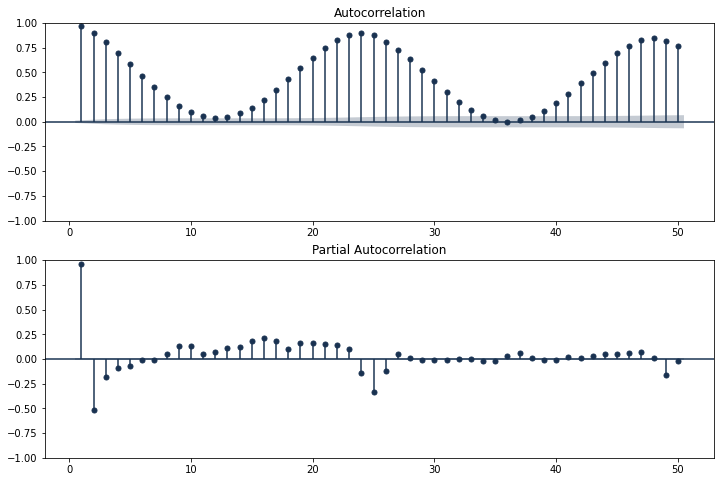

In [14]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train, lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train, lags=50, zero=False, ax=ax[1])
plt.show()

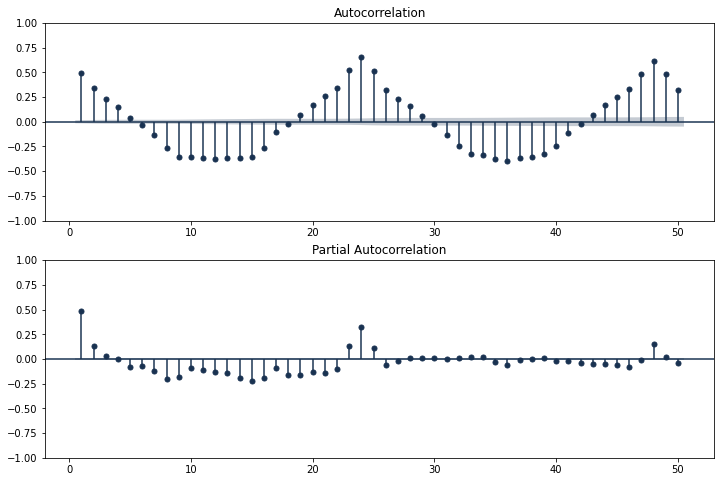

In [69]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train.diff().dropna(), lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train.diff().dropna(), lags=50, zero=False, ax=ax[1])
plt.show()

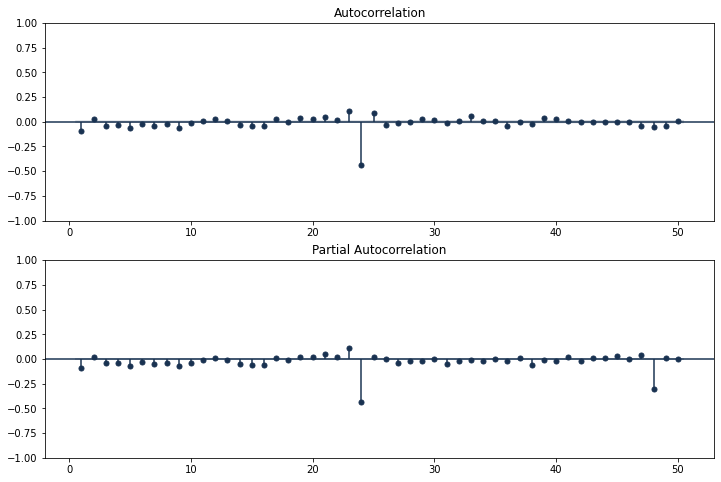

In [14]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train.diff().dropna().diff(24).dropna(), lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train.diff().dropna().diff(24).dropna(), lags=50, zero=False, ax=ax[1])
plt.show()

### Auto_ARIMA to determine inputs for SARIMAX

Since we represent the hourly, weekly and yearly as Fourier terms, we fit the auto_arima model on only the first three months of the data.

In [61]:
y_to_train = y.loc['2008-01-02':'2008-03-31']
exog_to_train = exog.loc['2008-01-02':'2008-03-31']

model1 = auto_arima(y=y_to_train, start_p=1, start_q=1,
          max_p=2, max_q=2, d=1, 
          m=24, exogenous=exog_to_train, 
          seasonal=True, stationary=False,
          information_criterion='aic',
          stepwise=True, njobs=-1, trace=True,
          error_action='ignore',
          suppress_warnings=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=41.04 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=20052.136, Time=1.15 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=19674.807, Time=25.20 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=19774.226, Time=35.92 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=20050.329, Time=3.60 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=20011.069, Time=2.10 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=19544.663, Time=194.10 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=200.44 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=38.28 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=19658.526, Time=188.84 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=19543.279, Time=309.52 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=19662.655, Time=56.26 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=272.96 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=59.02 sec
 ARIMA(2,1,1)(2,0,0

Running auto_arima, the best model that was found was:

```python
Best model:  ARIMA(2,1,1)(2,0,0)[24] intercept
```

However for a similar problem, [this notebook](https://nbviewer.org/github/pratha19/Springboard_capstone_project_1/blob/master/SDGE_energy_ML.ipynb#6.3) found the best model as:

```python
Best model:  ARIMA(2,1,1)(1,0,1)[24] intercept
```

We will try both sets of parameters for the SARIMAX model.

## SARIMAX

### SARIMAX(2, 1, 1)(2, 0, 0, 24) model on train data

In [63]:
# Fit model on train data
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):]

# Seasonality as exogenous variables
exog_to_train = exog.iloc[:(len(y)-365*24)]
exog_to_test = exog.iloc[(len(y)-365*24):]

model_train1 = SARIMAX(df_train['net_load_kW'], order=(2, 1, 1), seasonal_order=(2, 0, 0, 24), exogenous=exog_to_train)

In [64]:
results1 = model_train1.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95810D+00    |proj g|=  2.45285D-01


 This problem is unconstrained.



At iterate    5    f=  4.90070D+00    |proj g|=  8.58365D-03

At iterate   10    f=  4.88048D+00    |proj g|=  4.84065D-02

At iterate   15    f=  4.86576D+00    |proj g|=  2.50293D-02

At iterate   20    f=  4.86448D+00    |proj g|=  2.78095D-04

At iterate   25    f=  4.86446D+00    |proj g|=  1.83769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     35      1     0     0   3.109D-05   4.864D+00
  F =   4.8644556713999751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [65]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         net_load_kW   No. Observations:                26280
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 24)   Log Likelihood             -127837.895
Date:                             Mon, 01 Aug 2022   AIC                         255687.790
Time:                                     16:37:49   BIC                         255736.849
Sample:                                 01-02-2008   HQIC                        255703.631
                                      - 12-31-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1653      0.082     -2.026      0.043      -0.325      -0.005
ar.L2          0.0679      0.005     12.727      0.000       0.057       0.078
ma.L1          0.1924      0.082      2.361      0.018       0.033       0.352
ar.S.L24       0.4377      0.004     99.973      0.000       0.429       0.446
ar.S.L48       0.3159      0.005     66.394      0.000       0.307       0.325
sigma2       982.9570      5.851    167.986      0.000     971.488     994.426
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6152.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

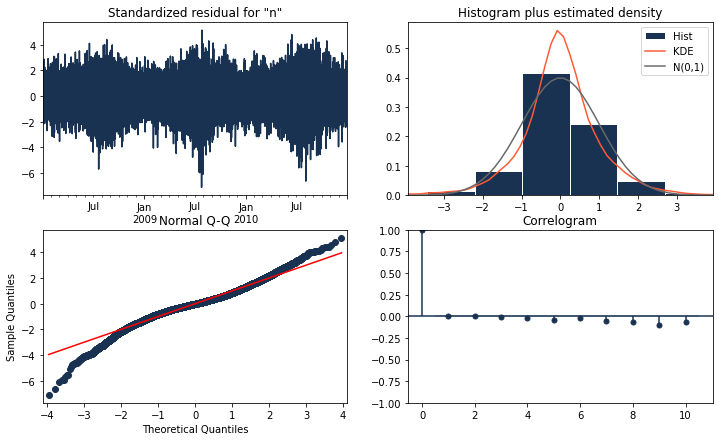

In [66]:
_ = results1.plot_diagnostics(figsize=(12, 7))

<AxesSubplot:xlabel='datetime'>

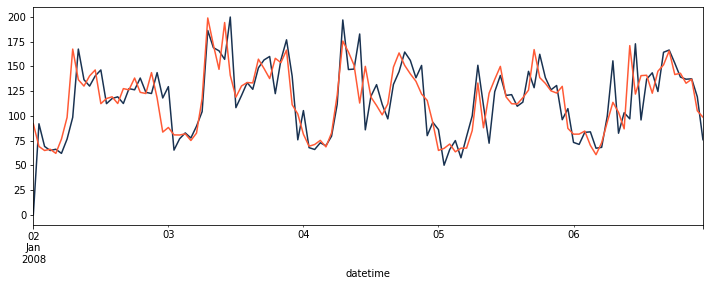

In [67]:
# Examine the prediction for a few days
fig, ax = plt.subplots(figsize=(12,4))
y_pred_train['2008-01-02':'2008-01-06'].plot(ax=ax)
y_train.loc['2008-01-02':'2008-01-06'].plot(ax=ax)

In [68]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

predictions = list()
for day in days_to_forecast:
  y_to_train = df['net_load_kW'].loc[day+pd.DateOffset(months=-24):day]
  exog_to_train = exog.loc[day+pd.DateOffset(months=-24):day]

  model = SARIMAX(y_to_train, order=(2, 1, 1), seasonal_order=(2, 0, 0, 24), exogenous=exog_to_train)
  model_fit = model.fit()
  output = model_fit.forecast(steps=24)
  predictions.append(output)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98319D+00    |proj g|=  2.33719D-01


 This problem is unconstrained.



At iterate    5    f=  4.92973D+00    |proj g|=  8.01032D-03

At iterate   10    f=  4.90626D+00    |proj g|=  3.03318D-02

At iterate   15    f=  4.89652D+00    |proj g|=  1.58892D-03

At iterate   20    f=  4.89651D+00    |proj g|=  8.81059D-04

At iterate   25    f=  4.89649D+00    |proj g|=  5.99635D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     44      1     0     0   2.332D-05   4.896D+00
  F =   4.8964854591228493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99059D+00    |proj g|=  2.36634D-01

At iterate    5    f=  4.93648D+00    |proj g|=  7.94531D-03

At iterate   10    f=  4.91328D+00    |proj g|=  3.19359D-02

At iterate   15    f=  4.90324D+00    |proj g|=  5.23670D-03

At iterate   20    f=  4.90312D+00    |proj g|=  2.09505D-03

At iterate   25    f=  4.90304D+00    |proj g|=  2.70083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98431D+00    |proj g|=  2.36202D-01

At iterate    5    f=  4.92728D+00    |proj g|=  1.02784D-02

At iterate   10    f=  4.90517D+00    |proj g|=  2.47869D-02

At iterate   15    f=  4.89253D+00    |proj g|=  8.03138D-04

At iterate   20    f=  4.89252D+00    |proj g|=  2.82159D-03

At iterate   25    f=  4.89248D+00    |proj g|=  1.91066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.93789D+00    |proj g|=  7.90528D-03

At iterate   10    f=  4.91511D+00    |proj g|=  3.21613D-02

At iterate   15    f=  4.90494D+00    |proj g|=  6.20983D-03

At iterate   20    f=  4.90483D+00    |proj g|=  2.57369D-03

At iterate   25    f=  4.90474D+00    |proj g|=  1.66514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   1.694D-05   4.905D+00
  F =   4.9047406617189750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98805D+00    |proj g|=  2.35287D-01

At iterate    5    f=  4.93405D+00    |proj g|=  7.96092D-03

At iterate   10    f=  4.90825D+00    |proj g|=  2.68238D-02

At iterate   15    f=  4.90109D+00    |proj g|=  9.74698D-04

At iterate   20    f=  4.90109D+00    |proj g|=  4.02457D-04

At iterate   25    f=  4.90108D+00    |proj g|=  5.66642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.93140D+00    |proj g|=  8.02160D-03

At iterate   10    f=  4.91047D+00    |proj g|=  2.47158D-02

At iterate   15    f=  4.89821D+00    |proj g|=  7.67431D-03

At iterate   20    f=  4.89811D+00    |proj g|=  1.85917D-04

At iterate   25    f=  4.89811D+00    |proj g|=  1.12745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   4.972D-06   4.898D+00
  F =   4.8981050785555551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.92666D+00    |proj g|=  8.05322D-03

At iterate   10    f=  4.90335D+00    |proj g|=  6.42949D-02

At iterate   15    f=  4.89323D+00    |proj g|=  9.34688D-04

At iterate   20    f=  4.89323D+00    |proj g|=  4.85063D-04

At iterate   25    f=  4.89323D+00    |proj g|=  2.03418D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   2.034D-05   4.893D+00
  F =   4.8932276074489991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99048D+00    |proj g|=  2.35602D-01

At iterate    5    f=  4.93411D+00    |proj g|=  8.33328D-03

At iterate   10    f=  4.91271D+00    |proj g|=  5.90204D-02

At iterate   15    f=  4.90030D+00    |proj g|=  2.19563D-03

At iterate   20    f=  4.90028D+00    |proj g|=  1.49591D-03

At iterate   25    f=  4.90025D+00    |proj g|=  6.21736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     35      1     0     0   

In [1]:
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

fig, ax = plt.subplots(4, 2, figsize=(14,16))
for day_to_plot in range(len(days_to_forecast)):

    day = days_to_forecast[day_to_plot]
    index = pred_indices[day_to_plot]
    y_pred = predictions[day_to_plot]
    y_test = df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)]

    # Plot actual vs predicted net energy usage for each of the chosen days
    plt.subplot(4, 2, day_to_plot+1)
    y_test.plot()
    y_pred.plot()
    plt.title(day)
    
    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    if write_data:
        
        # Starting the MLFlow run
        r = mlflow.start_run(run_name="sarimax")
        print("run-uuid:", r.info.run_uuid)

        for k, v in global_params.items():
            mlflow.log_param(k, v)
            mlflow.log_param("model", "sarimax")
            mlflow.log_param("datetime", day)
            mlflow.log_param("feature", "net_load_kW")
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2_score", r2)
        mlflow.end_run()
    
        # DataFrame for writing to SQL database
        day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
        day_forecast['prediction'] = y_pred
        day_forecast['run_id'] = r.info.run_uuid
        day_forecast['id'] = np.arange(index+1,index+25)
        forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
    forecasts = forecasts.set_index('id')
    forecasts.to_sql("forecast", con=db, if_exists="append")

print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")
plt.subplots_adjust(hspace=0.5)
plt.show()

NameError: name 'pd' is not defined

### SARIMAX(2, 1, 1)(1, 0, 1, 24) model on train data

In [15]:
# Fit model on train data
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):]

# Seasonality as exogenous variables
exog_to_train = exog.iloc[:(len(y)-365*24)]
exog_to_test = exog.iloc[(len(y)-365*24):]

model_train2 = SARIMAX(df_train['net_load_kW'], order=(2, 1, 1), seasonal_order=(1, 0, 1, 24), exogenous=exog_to_train)

In [17]:
results2 = model_train2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90781D+00    |proj g|=  2.09122D-01


 This problem is unconstrained.



At iterate    5    f=  4.85166D+00    |proj g|=  3.09278D-02

At iterate   10    f=  4.77341D+00    |proj g|=  3.63419D-02

At iterate   15    f=  4.74777D+00    |proj g|=  2.40173D-03

At iterate   20    f=  4.74745D+00    |proj g|=  1.78299D-03

At iterate   25    f=  4.74737D+00    |proj g|=  1.00835D-04

At iterate   30    f=  4.74736D+00    |proj g|=  2.10182D-03

At iterate   35    f=  4.74719D+00    |proj g|=  1.91764D-03

At iterate   40    f=  4.74717D+00    |proj g|=  6.39095D-04

At iterate   45    f=  4.74717D+00    |proj g|=  1.54094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     61   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [18]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        net_load_kW   No. Observations:                26280
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -124755.522
Date:                            Mon, 01 Aug 2022   AIC                         249523.044
Time:                                    21:32:18   BIC                         249572.103
Sample:                                01-02-2008   HQIC                        249538.885
                                     - 12-31-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2271      0.088     -2.585      0.010      -0.399      -0.055
ar.L2          0.0602      0.005     11.521      0.000       0.050       0.070
ma.L1          0.2544      0.088      2.899      0.004       0.082       0.426
ar.S.L24       0.9966      0.000   2584.462      0.000       0.996       0.997
ma.S.L24      -0.9067      0.002   -390.247      0.000      -0.911      -0.902
sigma2       776.5569      4.552    170.614      0.000     767.636     785.478
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6989.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

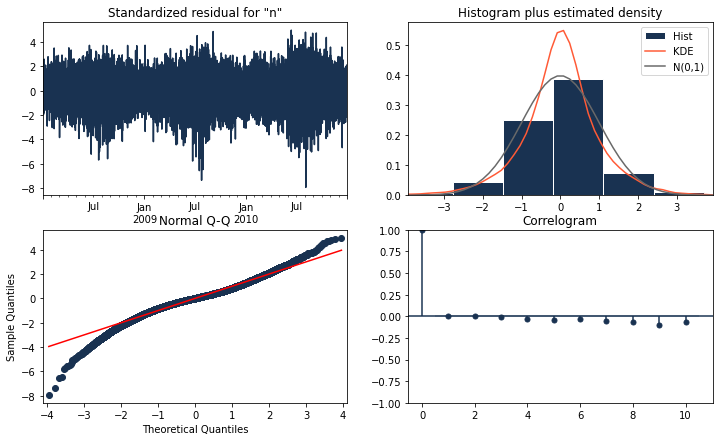

In [19]:
_ = results2.plot_diagnostics(figsize=(12, 7))

Mean Absolute Error (SARIMAX) = 20.165
Mean Squared Error (SARIMAX) = 777.607
R2 score (SARIMAX) = 0.973


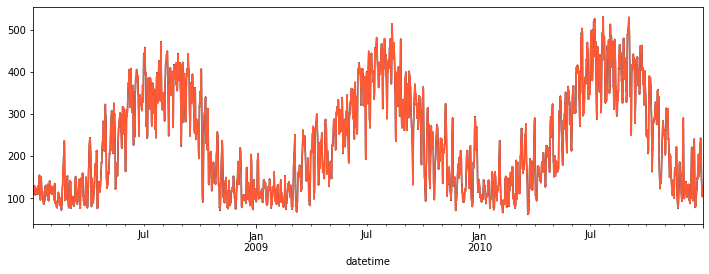

In [20]:
y_pred_train = results2.predict()
y_train = df_train['net_load_kW']

fig, ax = plt.subplots(figsize=(12,4))
y_pred_train.rolling(24).mean().plot(ax=ax)
y_train.rolling(24).mean().plot(ax=ax)

mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print(f"Mean Absolute Error (SARIMAX) = {mae.round(3)}")
print(f"Mean Squared Error (SARIMAX) = {mse.round(3)}")
print(f"R2 score (SARIMAX) = {r2.round(3)}")

<AxesSubplot:xlabel='datetime'>

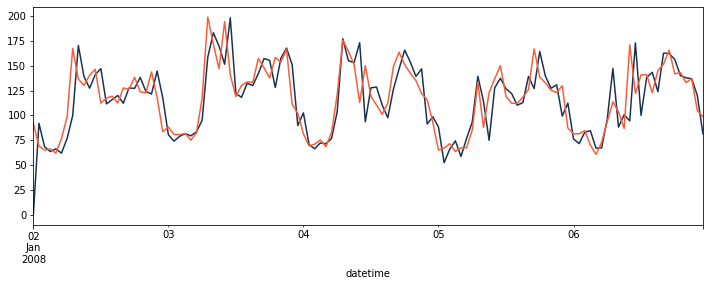

In [21]:
# Examine the prediction for a few days
fig, ax = plt.subplots(figsize=(12,4))
y_pred_train['2008-01-02':'2008-01-06'].plot(ax=ax)
y_train.loc['2008-01-02':'2008-01-06'].plot(ax=ax)

### SARIMAX(2,1,1)(1,0,1,24) forecast for 8 randomly chosen dates

In [22]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

predictions = list()
for day in days_to_forecast:
  y_to_train = df['net_load_kW'].loc[day+pd.DateOffset(months=-24):day]
  exog_to_train = exog.loc[day+pd.DateOffset(months=-24):day]

  model = SARIMAX(y_to_train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 24), exogenous=exog_to_train)
  model_fit = model.fit()
  output = model_fit.forecast(steps=24)
  predictions.append(output)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93387D+00    |proj g|=  2.00324D-01

At iterate    5    f=  4.87974D+00    |proj g|=  3.14134D-02

At iterate   10    f=  4.80095D+00    |proj g|=  3.50957D-02

At iterate   15    f=  4.77973D+00    |proj g|=  1.50088D-03

At iterate   20    f=  4.77920D+00    |proj g|=  8.92464D-04

At iterate   25    f=  4.77916D+00    |proj g|=  2.37325D-03

At iterate   30    f=  4.77915D+00    |proj g|=  2.43237D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.88623D+00    |proj g|=  2.89828D-02

At iterate   10    f=  4.81163D+00    |proj g|=  4.01516D-02

At iterate   15    f=  4.78614D+00    |proj g|=  4.31892D-03

At iterate   20    f=  4.78531D+00    |proj g|=  3.20887D-03

At iterate   25    f=  4.78528D+00    |proj g|=  1.25977D-04

At iterate   30    f=  4.78528D+00    |proj g|=  1.01742D-03

At iterate   35    f=  4.78522D+00    |proj g|=  1.30182D-03

At iterate   40    f=  4.78516D+00    |proj g|=  1.27834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     48      1     0     0   3.707D-05   4.785D+00
  F =   4.78515832452

 This problem is unconstrained.



At iterate    5    f=  4.87777D+00    |proj g|=  2.21512D-02

At iterate   10    f=  4.79441D+00    |proj g|=  3.33317D-02

At iterate   15    f=  4.77521D+00    |proj g|=  7.79705D-03

At iterate   20    f=  4.77440D+00    |proj g|=  1.47504D-02

At iterate   25    f=  4.77417D+00    |proj g|=  3.76645D-04

At iterate   30    f=  4.77410D+00    |proj g|=  4.62496D-03

At iterate   35    f=  4.77378D+00    |proj g|=  1.25613D-03

At iterate   40    f=  4.77378D+00    |proj g|=  6.73014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   2.301D-06   4.774D+00
  F =   4.77377879812

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94106D+00    |proj g|=  2.01932D-01

At iterate    5    f=  4.88751D+00    |proj g|=  2.90265D-02

At iterate   10    f=  4.81419D+00    |proj g|=  3.93974D-02

At iterate   15    f=  4.78802D+00    |proj g|=  3.67945D-03

At iterate   20    f=  4.78756D+00    |proj g|=  7.01488D-03

At iterate   25    f=  4.78708D+00    |proj g|=  2.71391D-03

At iterate   30    f=  4.78707D+00    |proj g|=  1.62053D-04

At iterate   35    f=  4.78704D+00    |proj g|=  1.40113D-03

At iterate   40    f=  4.78696D+00    |proj g|=  2.06768D-04

At iterate   45    f=  4.78695D+00    |proj g|=  9.24116D-05

At iterate   50    f=  4.78695D+00    |proj g|=  1.81894D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93909D+00    |proj g|=  2.01941D-01

At iterate    5    f=  4.88445D+00    |proj g|=  2.97836D-02

At iterate   10    f=  4.80104D+00    |proj g|=  3.95121D-02

At iterate   15    f=  4.78294D+00    |proj g|=  3.22468D-03

At iterate   20    f=  4.78285D+00    |proj g|=  2.84115D-03

At iterate   25    f=  4.78277D+00    |proj g|=  9.36267D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93631D+00    |proj g|=  2.02351D-01

At iterate    5    f=  4.88176D+00    |proj g|=  2.73204D-02

At iterate   10    f=  4.79829D+00    |proj g|=  3.72647D-02

At iterate   15    f=  4.77994D+00    |proj g|=  5.10433D-03

At iterate   20    f=  4.77984D+00    |proj g|=  5.59813D-03

At iterate   25    f=  4.77971D+00    |proj g|=  1.71173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.87687D+00    |proj g|=  3.27050D-02

At iterate   10    f=  4.79994D+00    |proj g|=  3.28212D-02

At iterate   15    f=  4.77602D+00    |proj g|=  2.04624D-03

At iterate   20    f=  4.77584D+00    |proj g|=  3.81998D-03

At iterate   25    f=  4.77579D+00    |proj g|=  2.18523D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   2.185D-05   4.776D+00
  F =   4.7757863690234874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93898D+00    |proj g|=  2.00482D-01

At iterate    5    f=  4.88436D+00    |proj g|=  2.04538D-02

At iterate   10    f=  4.80074D+00    |proj g|=  2.71395D-02

At iterate   15    f=  4.78344D+00    |proj g|=  4.47783D-02

At iterate   20    f=  4.78199D+00    |proj g|=  7.97573D-03

At iterate   25    f=  4.78141D+00    |proj g|=  3.83792D-04

At iterate   30    f=  4.78140D+00    |proj g|=  2.70900D-04

At iterate   35    f=  4.78138D+00    |proj g|=  2.80286D-03

At iterate   40    f=  4.78112D+00    |proj g|=  1.62076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

Day: 2011-09-01 23:00:00, mae: 54.509, mse: 4024.086, rmse: 63.436, r2: 0.802
run-uuid: c2ad6939b10d453385d90c225fc61ecc
Day: 2011-10-20 23:00:00, mae: 32.785, mse: 1613.873, rmse: 40.173, r2: 0.896
run-uuid: 3fd841c4c0554d0db4e01767e3445c4d
Day: 2011-01-09 06:00:00, mae: 22.141, mse: 678.924, rmse: 26.056, r2: 0.645
run-uuid: 0187a5eb98f9469ebd68932d43562e37
Day: 2011-10-22 21:00:00, mae: 75.698, mse: 9456.443, rmse: 97.244, r2: -2.316
run-uuid: 8e9cb81c559c4b6c8b2c4f542f112f84
Day: 2011-06-21 03:00:00, mae: 71.815, mse: 6473.816, rmse: 80.460, r2: 0.715
run-uuid: 741ac916e8f84b7f96dd42b738bd3e8c
Day: 2011-07-08 02:00:00, mae: 35.736, mse: 1880.314, rmse: 43.363, r2: 0.913
run-uuid: 230073629f9c44f38fc0a1206946c021
Day: 2011-08-19 00:00:00, mae: 56.112, mse: 5657.316, rmse: 75.215, r2: 0.867
run-uuid: 9176ed7cd7a246a4b131eb4f45f4e795
Day: 2011-04-15 07:00:00, mae: 27.815, mse: 1251.039, rmse: 35.370, r2: 0.790
run-uuid: e07c82fe55524d06a1c57621f044d3e3
Avg mae: 47.076, Avg mse: 3879.4

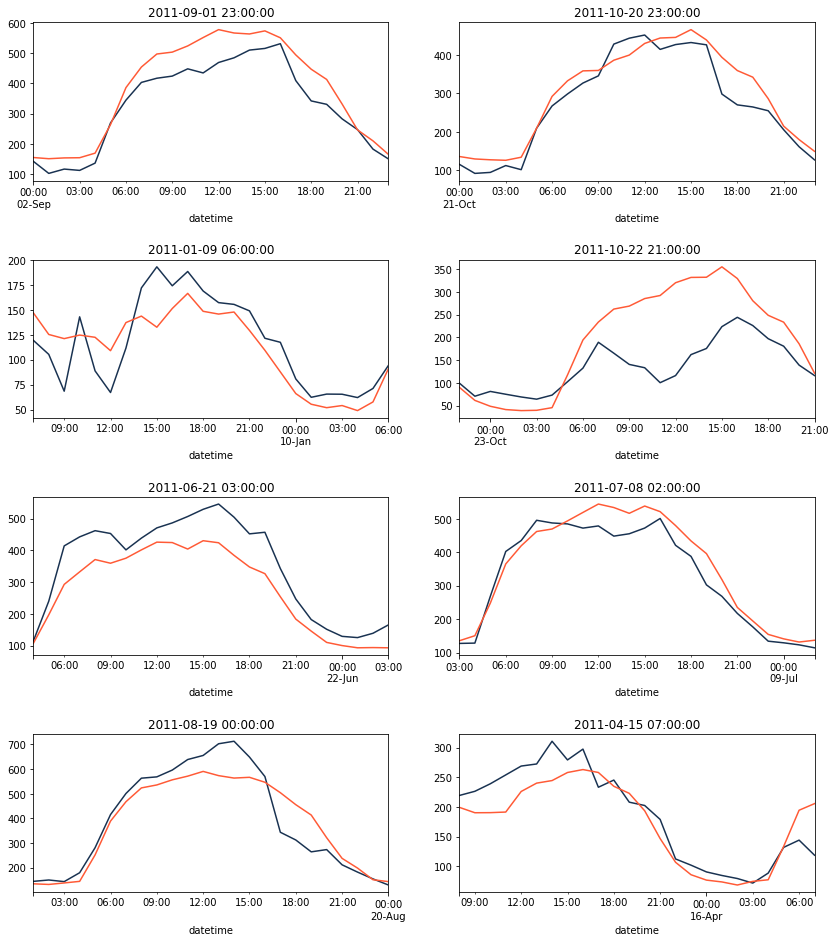

In [29]:
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
fig, ax = plt.subplots(4,2,figsize=(14,16))
for day_to_plot in range(len(days_to_forecast)):

    day = days_to_forecast[day_to_plot]
    index = pred_indices[day_to_plot]
    y_pred = predictions[day_to_plot]
    y_test = df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)]

    # Plot actual vs predicted net energy usage for each of the chosen days
    plt.subplot(4, 2, day_to_plot+1)
    y_test.plot()
    y_pred.plot()
    plt.title(day)
    
    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    if write_data:
        
        # Starting the MLFlow run
        r = mlflow.start_run(run_name="sarimax")
        print("run-uuid:", r.info.run_uuid)

        for k, v in global_params.items():
            mlflow.log_param(k, v)
            mlflow.log_param("model", "sarimax")
            mlflow.log_param("datetime", day)
            mlflow.log_param("feature", "net_load_kW")
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2_score", r2)
        mlflow.end_run()
    
        # DataFrame for writing to SQL database
        day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
        day_forecast['prediction'] = y_pred
        day_forecast['run_id'] = r.info.run_uuid
        day_forecast['id'] = np.arange(index+1,index+25)
        forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
    forecasts = forecasts.set_index('id')
    forecasts.to_sql("forecast", con=db, if_exists="append")

print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")
plt.subplots_adjust(hspace=0.5)
plt.show()